In [1]:
%matplotlib inline
import numpy as np
from ggplot import *
import pandas as pd
from langdetect import detect
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer,TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import r2_score, mean_squared_error, confusion_matrix,classification_report

import nltk
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns

from utils import detect_lang

/home/ramon/anaconda2/lib/python2.7/site-packages/ggplot/utils.py:81: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  pd.tslib.Timestamp,
/home/ramon/anaconda2/lib/python2.7/site-packages/ggplot/stats/smoothers.py:4: FutureWarning: The pandas.lib module is deprecated and will be removed in a future version. These are private functions and can be accessed from pandas._libs.lib instead
  from pandas.lib import Timestamp
/home/ramon/anaconda2/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
def add_language_to_reviews(df):
    df_reviews = pd.read_csv('data/reviews.csv')
    
    df_reviews["comments2"] = df_reviews.comments.apply(lambda x:str(x).decode('utf-8'))
    df_reviews['language']= df_reviews.comments2.apply(detect_lang)
    df_reviews.to_csv("data/reviews_with_lang.csv")
    

In [3]:
df_reviews = pd.read_csv('data/reviews_with_lang.csv')
df_reviews_eng = df_reviews[df_reviews.language=='en']

df_listing = pd.read_csv('data/listings.csv')


In [4]:
df_listing.columns

Index([u'id', u'listing_url', u'scrape_id', u'last_scraped', u'name',
       u'summary', u'space', u'description', u'experiences_offered',
       u'neighborhood_overview', u'notes', u'transit', u'access',
       u'interaction', u'house_rules', u'thumbnail_url', u'medium_url',
       u'picture_url', u'xl_picture_url', u'host_id', u'host_url',
       u'host_name', u'host_since', u'host_location', u'host_about',
       u'host_response_time', u'host_response_rate', u'host_acceptance_rate',
       u'host_is_superhost', u'host_thumbnail_url', u'host_picture_url',
       u'host_neighbourhood', u'host_listings_count',
       u'host_total_listings_count', u'host_verifications',
       u'host_has_profile_pic', u'host_identity_verified', u'street',
       u'neighbourhood', u'neighbourhood_cleansed',
       u'neighbourhood_group_cleansed', u'city', u'state', u'zipcode',
       u'market', u'smart_location', u'country_code', u'country', u'latitude',
       u'longitude', u'is_location_exact', u'prope

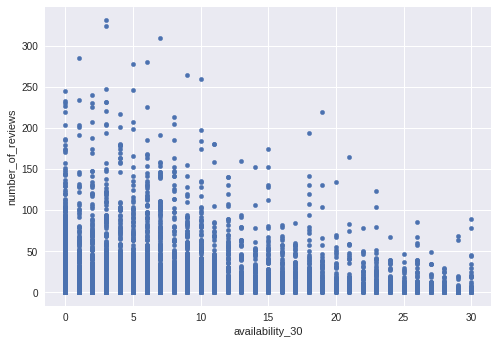

In [5]:
df_listing[df_listing.room_type=='Entire home/apt'].plot(kind='scatter',x='availability_30',y='number_of_reviews')

In [6]:
df_listing.room_type.unique()

array(['Private room', 'Entire home/apt', 'Shared room'], dtype=object)

In [7]:
df_reviews_eng = pd.merge(df_reviews_eng,df_listing[['id','review_scores_rating','review_scores_cleanliness','room_type','availability_30','availability_90','reviews_per_month']],left_on='listing_id',right_on='id')

In [8]:
df_reviews_eng.head()

,Unnamed: 0,listing_id,id_x,date,reviewer_id,reviewer_name,comments,language,id_y,review_scores_rating,review_scores_cleanliness,room_type,availability_30,availability_90,reviews_per_month
0,1,7878281,50115386,2015-10-09,45018962,Rotem,"AMAZING hosting, we arrived to Benita's appart...",en,7878281,99.0,10.0,Entire home/apt,6,6,0.69
1,3,7878281,58376102,2016-01-02,6789115,Nicola,"This apartment was beautiful, spacious, warm a...",en,7878281,99.0,10.0,Entire home/apt,6,6,0.69
2,4,7878281,71814574,2016-04-28,63494941,Claudio,BENITA AND KLEMENS WERE VERY KIND WITH US. THE...,en,7878281,99.0,10.0,Entire home/apt,6,6,0.69
3,5,7878281,74568125,2016-05-15,57750113,Sandeep,Yes. Klemens came with a bouquet of flowers an...,en,7878281,99.0,10.0,Entire home/apt,6,6,0.69
4,7,7878281,86698077,2016-07-17,19899121,Brian,Great experience. Hosts were responsive and fr...,en,7878281,99.0,10.0,Entire home/apt,6,6,0.69


In [9]:
groupy_per_lang = df_reviews.groupby('language').comments.count().sort_values(ascending = False)

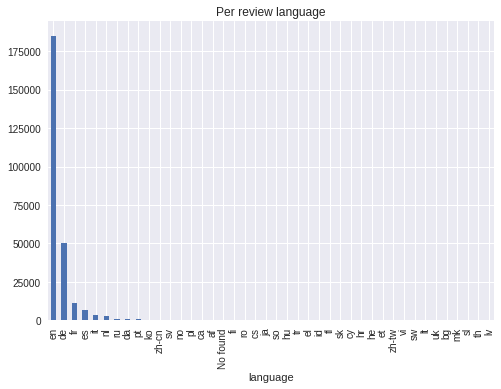

In [10]:
groupy_per_lang.plot.bar(title="Per review language")

In [11]:
def concat_comments(x):
    x = x.str.replace(r'[^a-zA-Z\d\s:]','')
    return "%s" % '- '.join(x)

df_reviews_eng = df_reviews_eng[df_reviews_eng.room_type=='Entire home/apt']
df_reviews_eng = df_reviews_eng[~df_reviews_eng.review_scores_rating.isnull()]
df_reviews_eng = df_reviews_eng[~df_reviews_eng.comments.str.contains('The host canceled this reservation')]

groupy = df_reviews_eng.groupby('listing_id').agg({'comments': [concat_comments,'count'], 'review_scores_rating': 'mean', 'availability_30':'mean','availability_90':'mean','reviews_per_month':'mean'})
groupy.columns = ["_".join(x) for x in groupy.columns.ravel()]

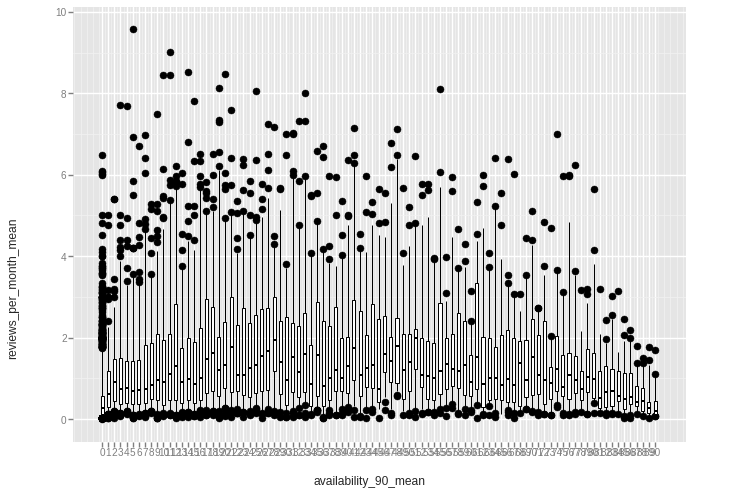

<ggplot: (8727291800053)>

In [12]:
ggplot(groupy,aes(x='availability_90_mean',y='reviews_per_month_mean'))+geom_boxplot()

In [15]:
groupy[['review_scores_rating_mean','availability_90_mean','availability_30_mean']].describe()

,review_scores_rating_mean,availability_90_mean,availability_30_mean
count,7541.000000,7541.000000,7541.000000
mean,93.315873,19.328471,4.737303
std,7.549269,24.972328,6.974533
min,20.000000,0.000000,0.000000
25%,90.000000,0.000000,0.000000
50%,95.000000,7.000000,0.000000
75%,100.000000,32.000000,7.000000
max,100.000000,90.000000,30.000000


### List of host

In [43]:
all_host_names = df_listing.host_name.str.lower()
all_host_names = all_host_names.unique().tolist()

In [48]:
porter = nltk.stem.porter.PorterStemmer()

def tokenizer_porter(text):
    return [porter.stem(word) for word in text.split()]

stop = nltk.corpus.stopwords.words('english')
stop =list(set(stop)-set(['no', 'not', 'never','don\'t','couldn\'t']))+all_host_names

groupy['good_bad_review']=np.where(groupy.review_scores_rating_mean>94,'good','bad')
X = groupy.comments_concat_comments.values
y = groupy.good_bad_review

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)

In [49]:
vectorizer = TfidfVectorizer(ngram_range=(2,3),tokenizer=tokenizer_porter,stop_words=stop,max_features=20000)
X_train_vectorized = vectorizer.fit_transform(X_train).todense()

In [53]:
X_train_vectorized = X_vectorized
X_test_vectorized = vectorizer.transform(X_test)

clf = MultinomialNB().fit(X_train_vectorized,y_train)

predicted = clf.predict(X_test_vectorized)

print confusion_matrix(predicted,y_test)
print classification_report(predicted,y_test)

[[412 174]
 [291 632]]
             precision    recall  f1-score   support

        bad       0.59      0.70      0.64       586
       good       0.78      0.68      0.73       923

avg / total       0.71      0.69      0.70      1509



In [54]:
def show_most_informative_features(vectorizer, clf, n=20):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print "\t%.4f\t%-15s\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2)
        
show_most_informative_features(vectorizer,clf,n=40)

	-10.9611	etienn wa      		-6.1564	wa veri        
	-10.9611	marylis wa     		-6.4200	apart wa       
	-10.9611	mauric wa      		-6.6504	veri nice      
	-10.9611	nestor wa      		-6.6996	wa great       
	-10.9611	no toilet      		-6.8198	highli recommend
	-10.9611	rudi wa        		-6.8475	everyth need   
	-10.9611	stay vinni     		-6.9496	wa perfect     
	-10.9611	veri dirti     		-7.0040	public transport
	-10.9611	viliu wa       		-7.0067	great locat    
	-10.9611	vinni great    		-7.0078	veri clean     
	-10.9611	vinni place    		-7.0143	great host     
	-10.9611	vinni wa       		-7.0253	would definit  
	-10.9486	wa howev       		-7.0762	recommend thi  
	-10.9377	veri thin      		-7.1265	everyth wa     
	-10.9225	shower head wa 		-7.1974	place wa       
	-10.9210	key becaus     		-7.2178	apart veri     
	-10.9193	not veri clean 		-7.2251	thi apart      
	-10.9181	bit disappoint 		-7.2331	veri help      
	-10.9166	signal wa      		-7.2549	stay berlin    
	-10.9100	natur histori museu